In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

In [2]:
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

id2color = { label.id : np.asarray(label.color) for label in labels }
color2id = { label.color : label.id for label in reversed(labels) }

In [3]:
input_image_size = (2048, 1024) # => 2 * (1024, 1024) => 2* resized_to_img_size, because FCN
img_size = (128, 128)
num_classes = len(labels)

In [4]:
def image_preprocessing(filename_pair, image_size):
    image = Image.open(filename_pair[0])
    mask = Image.open(filename_pair[1])

    image_split1, image_split2 = image.crop([0, 0, 1024, 1024]), image.crop([1024, 0, 2048, 1024])
    mask_split1, mask_split2 = mask.crop([0, 0, 1024, 1024]), mask.crop([1024, 0, 2048, 1024])

    image_split1 = image_split1.resize(image_size)
    image_split2 = image_split2.resize(image_size)
    mask_split1 = mask_split1.resize(image_size, resample=Image.Resampling.NEAREST)
    mask_split2 = mask_split2.resize(image_size, resample=Image.Resampling.NEAREST)


    image_split1 = np.array(image_split1)/ 255
    image_split2 = np.array(image_split2)/ 255
    mask_split1 = np.array(mask_split1)
    mask_split2 = np.array(mask_split2)

    image.close()
    mask.close()

    return (image_split1, mask_split1), (image_split2, mask_split2)

In [5]:
def find_labels_vectorized(mask, mapping):
    mask = mask[:,:,:3]
    flattened = mask.reshape(-1, 3)
    u,inv = np.unique(flattened, return_inverse = True, axis=0)
    u = [tuple(x) for x in u]
    labeled = np.array([mapping[x] for x in u])[inv].reshape(img_size)

    return labeled

In [6]:
#handle files in directories
segmented = 'data/segmented/'
images = 'data/images/'

In [ ]:
def get_file_pairs(images_path, segmented_path):
    locations = os.listdir(images_path)
    print(locations)

    data_pairs = []

    for location in locations:
        for img_file in os.listdir(images_path + location):
            id = img_file[:len(location)+15]
            data_pairs.append((images_path + location + '/' + id + 'leftImg8bit.png', segmented_path + location + '/' + id + 'gtFine_color.png' ))

    return data_pairs

In [ ]:
def preprocess_data(data_pairs):
    images = []
    masks = []
    masks_enc = []
    for pair in tqdm(data_pairs, desc = 'preprocessing: '):
        pair1, pair2 = image_preprocessing(pair, img_size)

        images.append(pair1[0])
        masks.append(pair1[1])
        masks_enc.append(find_labels_vectorized(pair1[1], color2id))

        images.append(pair2[0])
        masks.append(pair2[1])
        masks_enc.append(find_labels_vectorized(pair2[1], color2id))

    return images, masks, masks_enc


In [ ]:
def draw_samples(images, masks, masks_enc):
    plt.figure(figsize=[20, 14])

    for i in range(2):
        random_index = random.randint(0,len(images))
        img = images[random_index]
        msk = masks[random_index]
        enc = masks_enc[random_index]
        tmp = np.zeros([enc.shape[0], enc.shape[1], 3])

        for row in range(enc.shape[0]):
            for col in range(enc.shape[1]):
                tmp[row, col, :] = id2color[enc[row, col]]
                tmp = tmp.astype('uint8')

        plt.subplot(2, 3, i*3 + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.gca().set_title('Sample Image {}'.format(str(i+1)))

        plt.subplot(2, 3, i*3 + 2)
        plt.imshow(msk)
        plt.axis('off')
        plt.gca().set_title('Sample Mask {}'.format(str(i+1)))

        plt.subplot(2, 3, i*3 + 3)
        plt.imshow(tmp)
        plt.axis('off')
        plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))

    plt.subplots_adjust(wspace=0, hspace=0.1)

## TRAINING AND VALIDATION DATASETS

In [ ]:
file_pairs = get_file_pairs(images+'train/', segmented+'train/')

random.shuffle(file_pairs)
train_file_pairs, val_file_pairs = np.split(file_pairs, [int(len(file_pairs)*0.85)])


In [ ]:
train_images, train_masks, train_masks_enc = preprocess_data(train_file_pairs)
draw_samples(train_images, train_masks, train_masks_enc)

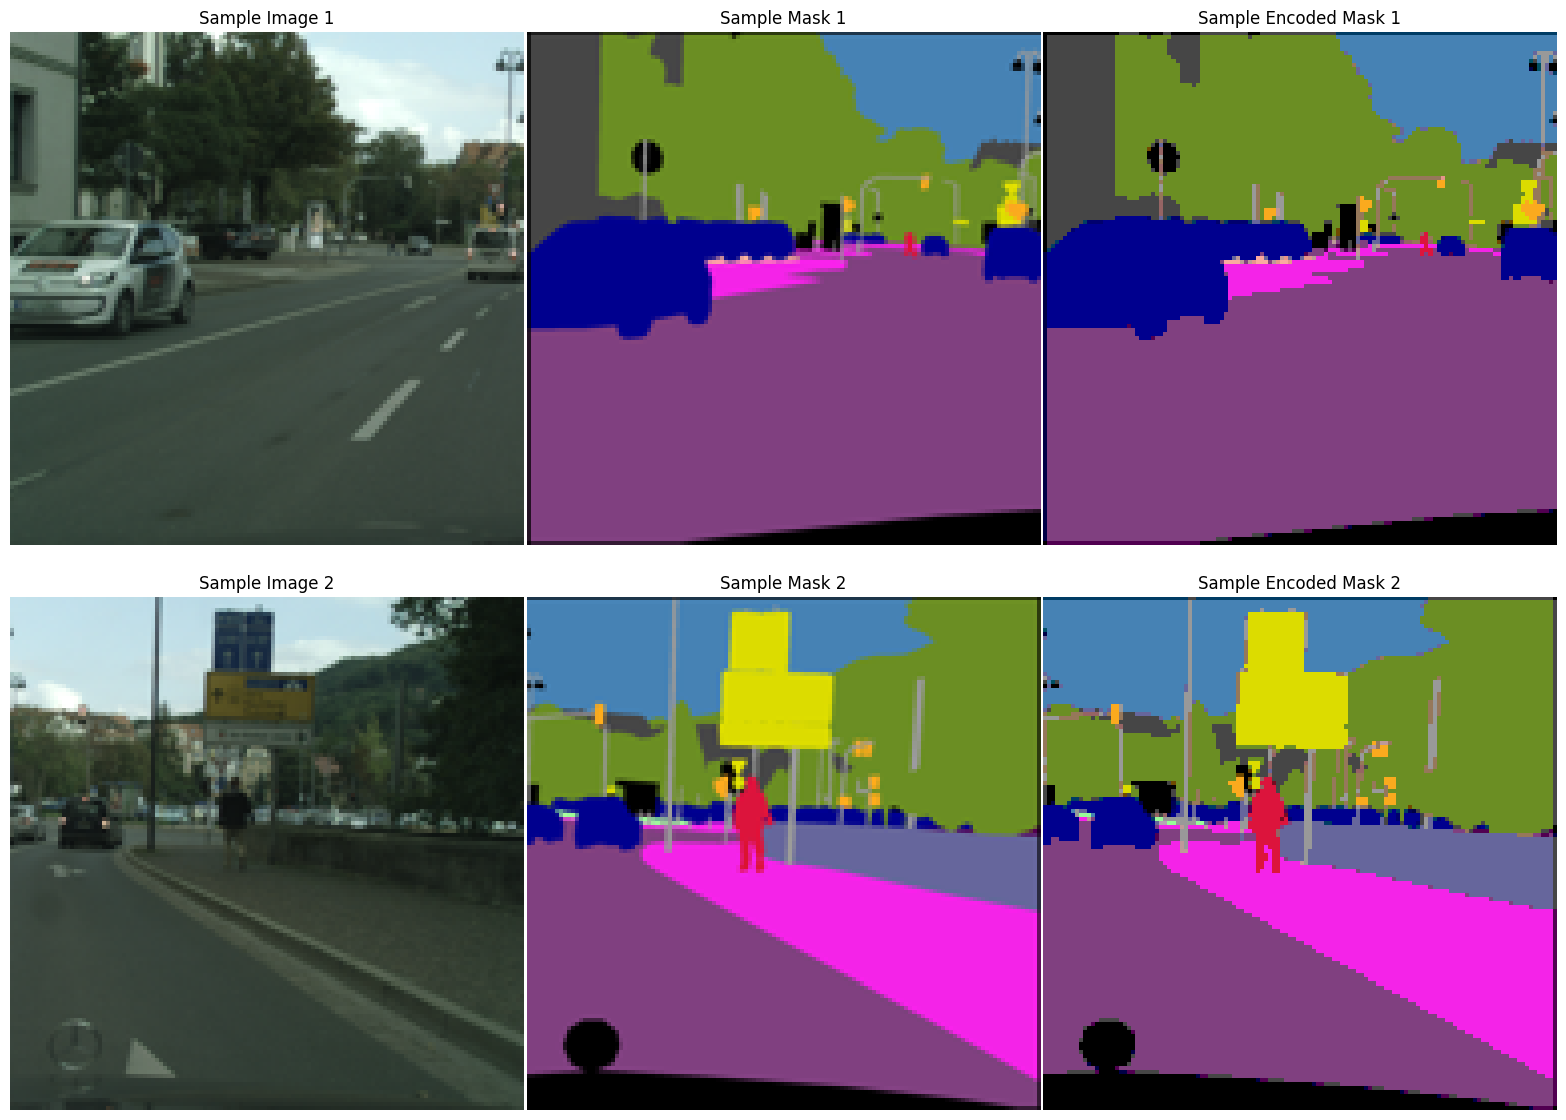

In [ ]:
del train_masks

train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks_enc))

train_dataset_path = 'datasets/training_dataset'
train_dataset.save(train_dataset_path)

del train_images
del train_masks_enc
del train_dataset

In [ ]:
val_images, val_masks, val_masks_enc = preprocess_data(val_file_pairs)

In [ ]:
del val_masks

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks_enc))

val_dataset_path = 'datasets/validation_dataset'
val_dataset.save(val_dataset_path)

del val_images
del val_masks_enc
del val_dataset

## TEST DATASET

In [ ]:
file_pairs = get_file_pairs(images+'val/', segmented+'val/')


test_images, test_masks, test_masks_enc = preprocess_data(file_pairs)
draw_samples(test_images, test_masks, test_masks_enc)

In [ ]:
del test_masks

test_images = np.stack(test_images).astype('float32')
test_masks_enc = np.stack(test_masks_enc).astype('float32')

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks_enc))

test_dataset_path = 'datasets/testing_dataset'
test_dataset.save(test_dataset_path)

del test_images
del test_masks_enc
del test_dataset

## DATASET TO PREDICT

In [ ]:

locations = os.listdir(images + '/test')
print(locations)

predict_files = []

for location in locations:
  for img_file in os.listdir(images + 'test/'+ location):
    id = img_file[:len(location)+15]
    predict_files.append(images+'test/'+location+'/'+id+'leftImg8bit.png')
random.shuffle(predict_files)

print(predict_files[0])


In [ ]:
predict_images = []

for f in tqdm(predict_files[:100], desc = 'Building Dataset to predict: '):
    image = Image.open(f)
    image = image.resize((1024,512))


    predict_images.append(np.array(image))

    image.close()

In [ ]:
predict_images = np.array(predict_images)

predict_dataset = tf.data.Dataset.from_tensor_slices(predict_images)

predict_dataset_path = 'datasets/prediction_dataset'
predict_dataset.save(predict_dataset_path)